In [1]:
import pandas as pd
import numpy as np
import torch
from transformer_time_series_enc_dec import train_model,InformerForecaster,create_dataloaders,TrainConfig,inverse_transform
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# Load and preprocess data
# -----------------------------
csv_path = r"D:\Quan\Quants\Neural Network\financial_attention\1h_data_20220101_20250601.csv"
closes = pd.read_csv(csv_path, index_col=0, parse_dates=True)[['SOL', 'ETH', 'BTC','ADA','XRP','LTC','TRX','LINK','DOT','DOGE']]


config = {
    "d_input": len(closes.columns),
    "d_model": 16,
    "n_heads": 4,
    "d_ff": 16,
    "enc_layers": 3,
    "dec_layers": 2,
    "dropout": 0.0,
    "distill": False,
    "enc_len": 96,
    "guiding_len": 48,
    "pred_len": 24,
    "factor": 5,
    "distill":True
}

train_loader, val_loader, scaler, asset_idx = create_dataloaders(closes, enc_len=config["enc_len"],
                                                                    pred_len=config["pred_len"],
                                                                    batch_size=32, val_ratio=0.1, asset_name="SOL")
model = InformerForecaster(config, asset_index=asset_idx)

In [3]:
closes

,SOL,ETH,BTC,ADA,XRP,LTC,TRX,LINK,DOT,DOGE
timestamp,,,,,,,,,,
2022-01-01 00:00:00+00:00,172.42,3723.33,46663.3,1.329982,0.83882,149.22,0.075930,20.02377,27.2700,0.171951
2022-01-01 01:00:00+00:00,172.83,3725.02,46793.7,1.328465,0.83911,148.31,0.075885,19.96571,27.2110,0.171860
2022-01-01 02:00:00+00:00,172.70,3727.54,46789.2,1.325466,0.84216,148.05,0.075852,19.88366,27.1850,0.171667
2022-01-01 03:00:00+00:00,172.90,3723.69,46844.0,1.325690,0.84295,147.88,0.075854,19.78830,27.1916,0.171317
2022-01-01 04:00:00+00:00,171.53,3708.72,46716.3,1.308206,0.83507,147.09,0.075703,19.56234,26.9299,0.170304
...,...,...,...,...,...,...,...,...,...,...
2025-05-31 20:00:00+00:00,157.50,2542.99,104800.0,0.690130,2.19501,87.68,0.266555,14.13086,4.1053,0.194531
2025-05-31 21:00:00+00:00,157.75,2542.98,104885.2,0.691366,2.19578,87.86,0.266146,14.15699,4.1034,0.194910
2025-05-31 22:00:00+00:00,157.01,2534.00,104721.7,0.685698,2.17952,87.39,0.265442,14.08654,4.0810,0.193299


In [4]:
# training config
tcfg = TrainConfig(learning_rate=1e-4, weight_decay=0.01, max_steps=3000, warmup_steps=200, use_amp=True, device="cuda")
model, train_hist, val_hist, steps_hist = train_model(model, train_loader, val_loader, tcfg, asset_index=asset_idx)


total_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_learnable_params:,}")

2025-10-15 15:44:45,322 | INFO | Using fused AdamW: True


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


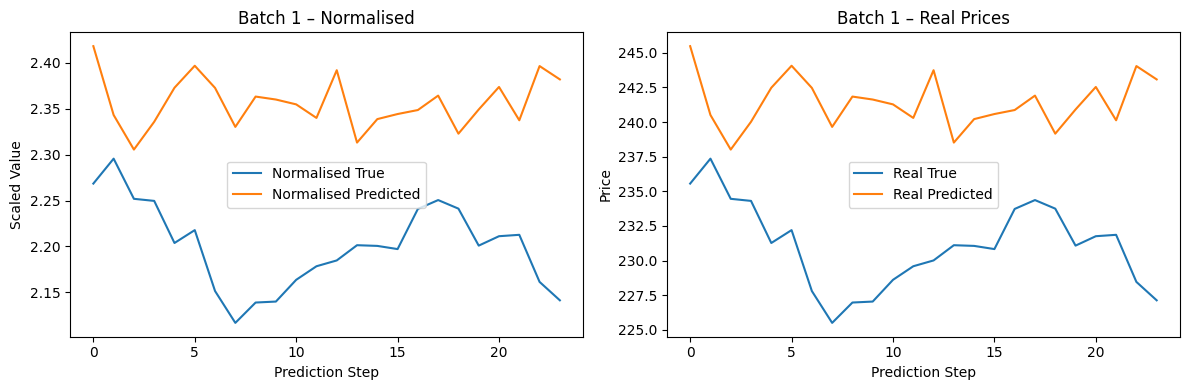

True std: 0.045135584
Pred std: 0.027335988


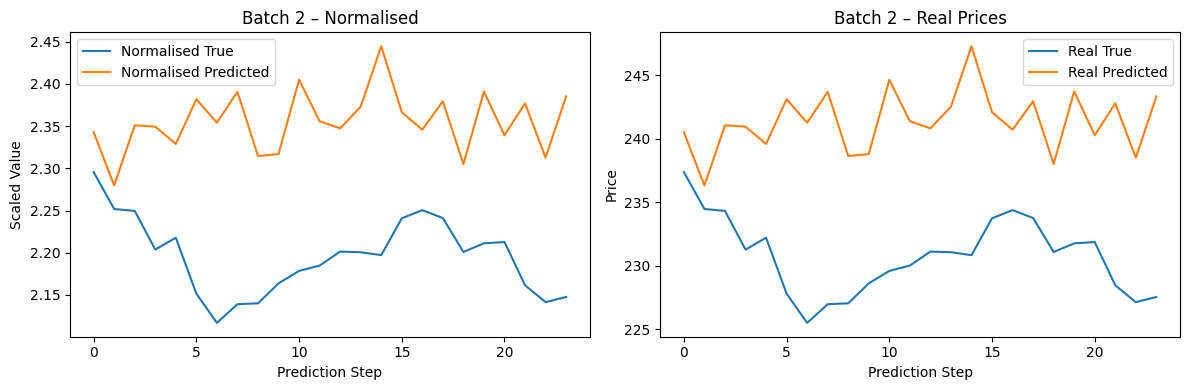

True std: 0.04404684
Pred std: 0.03570435


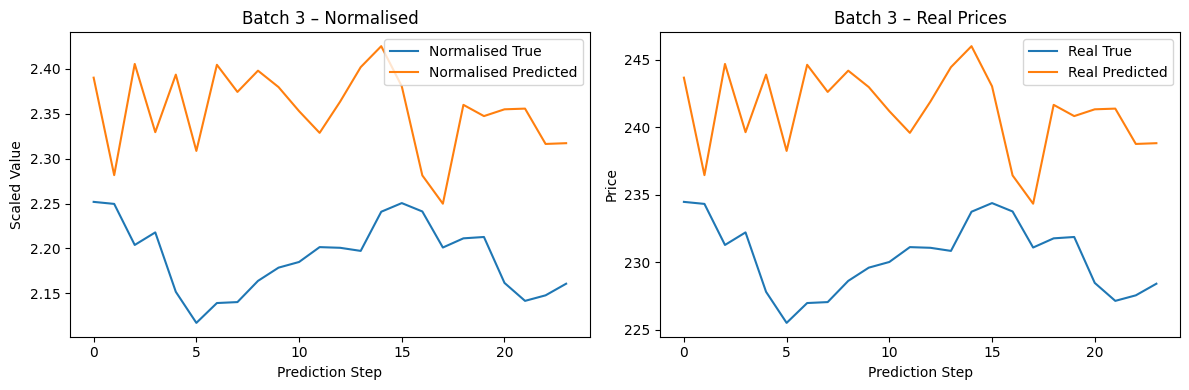

True std: 0.039329603
Pred std: 0.044180084


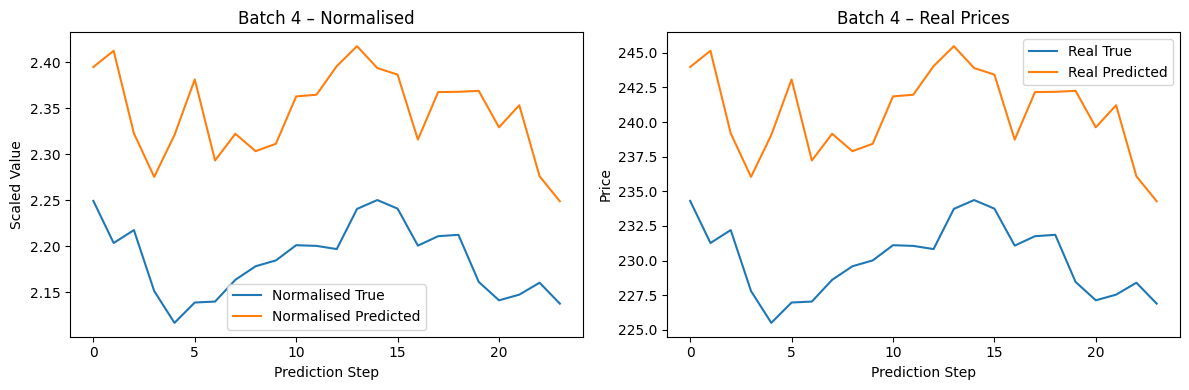

True std: 0.03847659
Pred std: 0.045520633


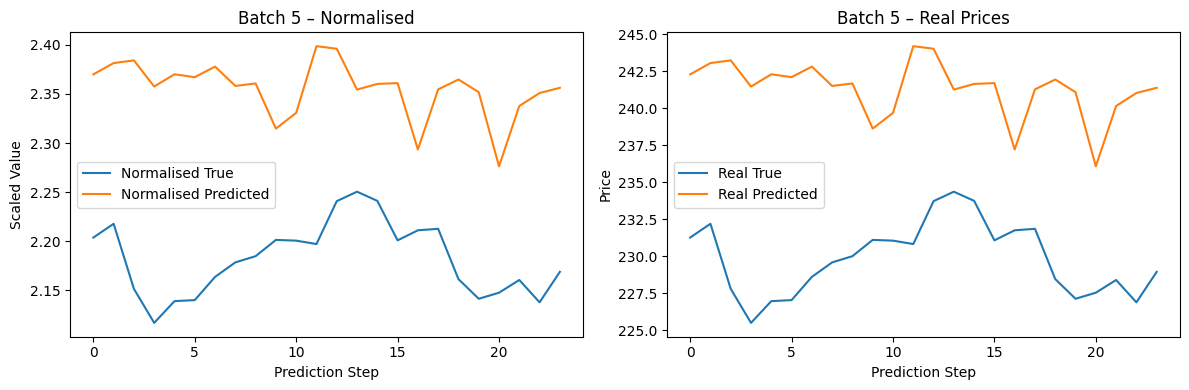

True std: 0.036187734
Pred std: 0.028104862


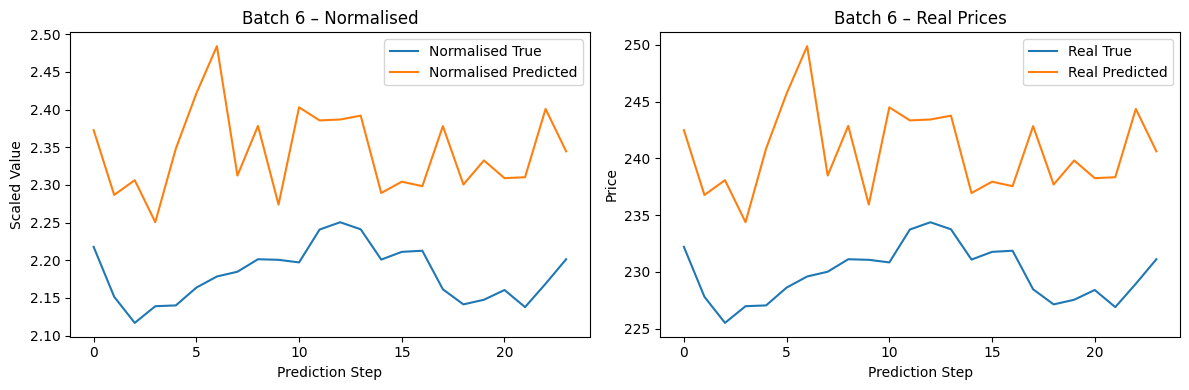

True std: 0.03613077
Pred std: 0.05466676


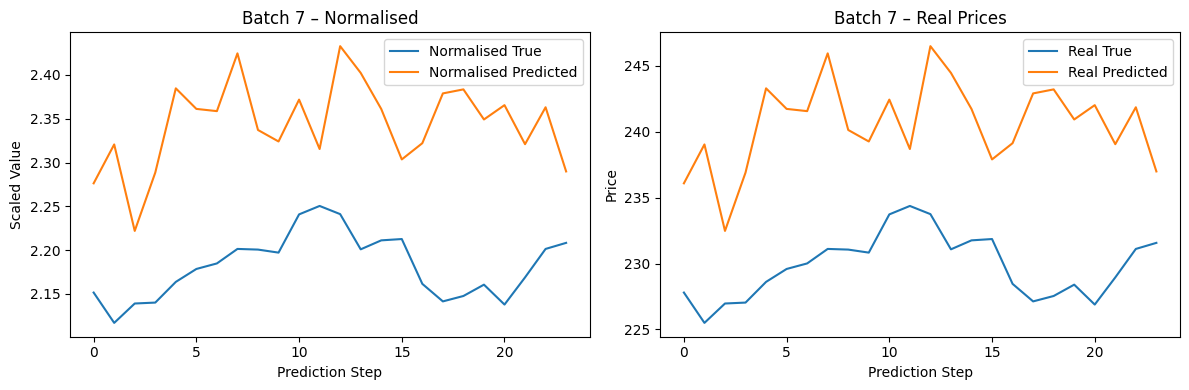

True std: 0.03578756
Pred std: 0.047709003


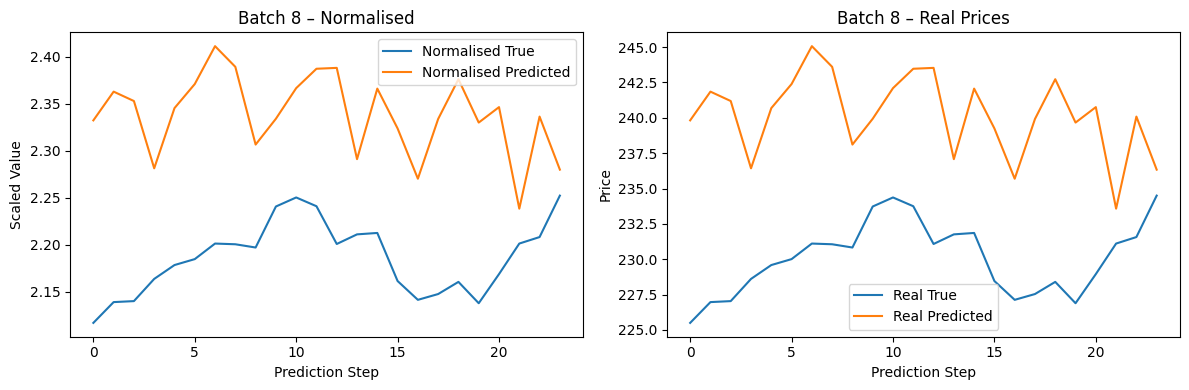

True std: 0.037871934
Pred std: 0.042190317


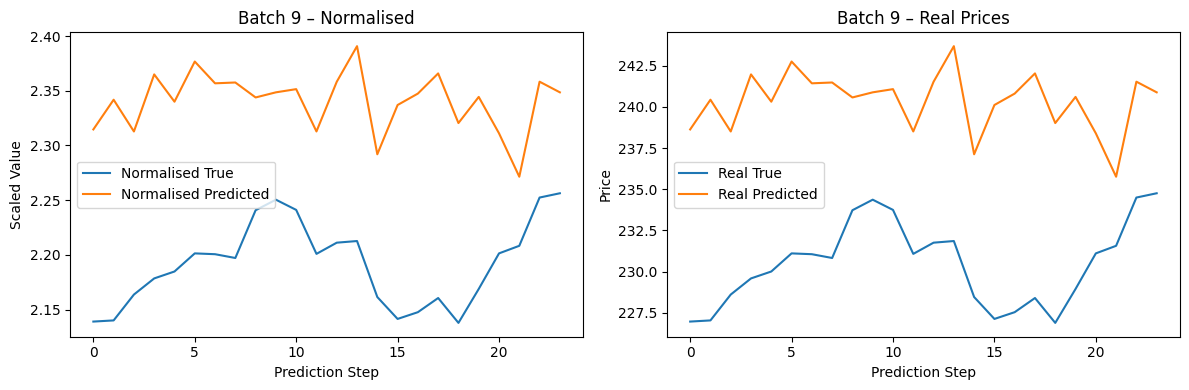

True std: 0.037550308
Pred std: 0.026766334


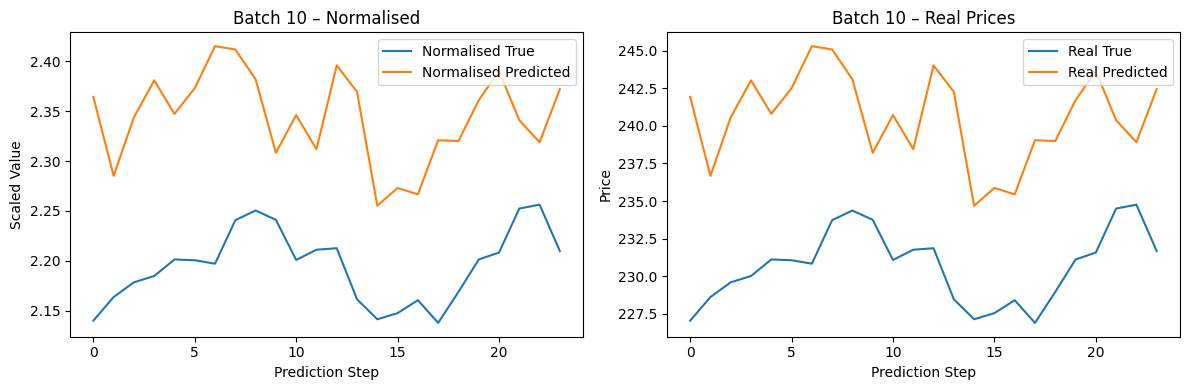

True std: 0.036055926
Pred std: 0.044096343


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Choose how many batches you want to visualize
num_batches_to_plot = 10  

with torch.no_grad():
    for i, x in enumerate(val_loader):
        x = x.to(device)
        y_pred = model(x)                         # [B, pred_len]
        y_true = x[:, -model.pred_len:, asset_idx] # [B, pred_len]

        # Move to CPU
        y_pred = y_pred.cpu().numpy()
        y_true = y_true.cpu().numpy()

        # Inverse transform to real prices
        y_pred_price = inverse_transform(y_pred.flatten(), scaler, asset_idx, config["d_input"])
        y_true_price = inverse_transform(y_true.flatten(), scaler, asset_idx, config["d_input"])

        # --- Plot both versions ---
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Normalised scale
        axes[0].plot(y_true.flatten(), label="Normalised True")
        axes[0].plot(y_pred.flatten(), label="Normalised Predicted")
        axes[0].set_title(f"Batch {i+1} – Normalised")
        axes[0].set_xlabel("Prediction Step")
        axes[0].set_ylabel("Scaled Value")
        axes[0].legend()

        # Real-price scale
        axes[1].plot(y_true_price, label="Real True")
        axes[1].plot(y_pred_price, label="Real Predicted")
        axes[1].set_title(f"Batch {i+1} – Real Prices")
        axes[1].set_xlabel("Prediction Step")
        axes[1].set_ylabel("Price")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

        true = y_true.flatten()
        pred = y_pred.flatten()

        print("True std:", np.std(true))
        print("Pred std:", np.std(pred))

        if i + 1 >= num_batches_to_plot:
            break



In [ ]:
torch.cuda.is_available()

True

In [ ]:
device

device(type='cuda')

In [ ]:
pd.DataFrame(train_hist, columns=['Train Loss'])

,Train Loss
0,1.322163
1,1.252960
2,1.254444
3,1.318944
4,0.991519
...,...
295,0.006946
296,0.002815
297,0.004629
298,0.004532


In [ ]:
pd.DataFrame(val_hist)

,0,1
0,0,0.544684
1,100,0.186834
2,200,0.844470
3,300,0.483115
4,400,0.294861
5,500,0.241768
6,600,0.048328
7,700,0.087390
8,800,0.073002
9,900,0.051991


In [ ]:

df_train = pd.DataFrame({
    "Step": steps_hist,
    "Loss": train_hist,
    "Type": "Train"
})
if val_hist:
    val_steps, val_losses = zip(*val_hist)
    df_val = pd.DataFrame({
        "Step": val_steps,
        "Loss": val_losses,
        "Type": "Validation"
    })
    df_loss = pd.concat([df_train, df_val], ignore_index=True)
else:
    df_loss = df_train

fig = px.line(df_loss, x="Step", y="Loss", color="Type", title="Training and Validation Loss")
fig.show()